# Best visual model


In [2]:
 
import tensorflow as tf
 
from tensorflow.keras import regularizers
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, Dense, LSTM,Reshape, Flatten,MaxPooling2D,ConvLSTM2D,Activation, Bidirectional,AveragePooling2D
from tensorflow.keras.layers import  TimeDistributed, Conv2D,Dropout,GRU,BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg19 import VGG19
regu = regularizers.l1_l2(l1=1e-5, l2=1e-4)
momentum = .9
 
input_dim = (160  ,160)
BATCH_SIZE = 32
frame_rate = 8
binary_mode = False
preprocess = True

main_genre = ["Horror","Thriller","Action","Comedy","Adventure","Sci-Fi","Romance","Drama","Mystery"]

num_classes = len(main_genre)
#
#pretrained = tf.keras.Model(i3d_model.inputs, i3d_model.layers[-1].output)
#for layer in pretrained.layers:
#    layer.trainable = True
#
base_model = tf.keras.applications.InceptionResNetV2(
    include_top=None,
    weights="imagenet",
    input_tensor=None,
    input_shape= (input_dim[0], input_dim[1], 3),
    pooling=None,
    classes=1000,
    classifier_activation="sigmoid",
)
 
for layer in base_model.layers[:-4]:
    layer.trainable = False# create a Sequential model
base_model = tf.keras.Model(base_model.inputs, base_model.layers[-3].output)
visual_model = Sequential()# add vgg model for 5 input images (keeping the right shape
visual_model.add(Input(shape = (frame_rate, input_dim[0], input_dim[1], 3)))
visual_model.add(TimeDistributed(base_model))
 
# 1st layer group
visual_model.add(TimeDistributed(Conv2D(16, (3, 3), activation="relu",name="conv1",
                 strides=(1, 1), padding="same"))  )
visual_model.add(TimeDistributed(BatchNormalization(momentum=momentum)))
visual_model.add(TimeDistributed(Flatten()))
visual_model.add(GRU(64, return_sequences=True))
visual_model.add(GRU(32, return_sequences=False))
 
visual_model.add(Flatten())
 
visual_model.add(Dense(1024, activation='relu', name='vis_dense_1'))
visual_model.add(Dropout(0.5))
visual_model.add(Dense(512, activation='relu', name='vis_dense_2'))
visual_model.add(Dropout(0.5))
visual_model.add(Dense(num_classes,activation='sigmoid', name='vis_dense_3'))
import tensorflow
optimizer = tensorflow.keras.optimizers.Nadam(
    learning_rate=0.0001)
 
visual_model.compile(
    optimizer,
    loss=  [tf.keras.losses.BinaryCrossentropy(
        from_logits=False,
        label_smoothing=0.1,
        reduction="auto",
        name="binary_crossentropy")],
    metrics=[tf.keras.metrics.BinaryAccuracy(
        name="binary_accuracy", dtype=None, threshold=0.5)
        ,tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
)
visual_model.build(input_shape = (input_dim[0], input_dim[1], 3))
print(visual_model.summary())
 


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 8, 3, 3, 1536)    54332128  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 8, 3, 3, 16)      221200    
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 8, 3, 3, 16)      64        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 8, 144)           0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 8, 64)             4

In [3]:
from tensorflow import keras

from tensorflow.keras.models import Sequential
visual_model.load_weights('checkpoints_multilabel\weights.02-0.44-0.42.hdf5')
print('Load weights')

Load weights


# Best Audio Model

In [4]:
audio_model = Sequential()# add vgg model for 5 input images (keeping the right shape
audio_model.add(tf.keras.layers.InputLayer(input_shape=(345)))

audio_model.add(Dense(416, activation='relu', name='aud_dense_1'))
audio_model.add(Dense(352, activation='relu', name='aud_dense_2'))
audio_model.add(Dense(32, activation='relu', name='aud_dense_3'))
audio_model.add(Dense(32, activation='relu', name='aud_dense_4'))
audio_model.add(Dense(num_classes, activation='sigmoid', name='aud_dense_5'))

audio_model.compile(
    optimizer,
    loss=  [tf.keras.losses.BinaryCrossentropy(
        from_logits=False,
        label_smoothing=0.1,
        reduction="auto",
        name="binary_crossentropy")],
    metrics=[tf.keras.metrics.BinaryAccuracy(
        name="binary_accuracy", dtype=None, threshold=0.5)
        ,tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
)
audio_model.build(input_shape = (input_dim[0], input_dim[1], 3))
print(audio_model.summary())
audio_model.load_weights('checkpoints_audio/weights.20-0.58-0.64.hdf5')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 aud_dense_1 (Dense)         (None, 416)               143936    
                                                                 
 aud_dense_2 (Dense)         (None, 352)               146784    
                                                                 
 aud_dense_3 (Dense)         (None, 32)                11296     
                                                                 
 aud_dense_4 (Dense)         (None, 32)                1056      
                                                                 
 aud_dense_5 (Dense)         (None, 9)                 297       
                                                                 
Total params: 303,369
Trainable params: 303,369
Non-trainable params: 0
_________________________________________________________________
None


# Find Multi-Modal

In [5]:
from keras.layers import concatenate
import tensorflow.keras.backend as K
from keras.utils.vis_utils import plot_model
def custom_hamming_loss(y_true, y_pred):
    # Avoid divide by 0

    y_true= K.cast(y_true, 'float')
    y_pred= K.cast(y_pred, 'float')

    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    
    loss = K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))
    
    # Multi-task loss
    return loss
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def build_model(hp):

    for layer in visual_model.layers[:-4]:
        layer.trainable = False# create a Sequential model

    visual_model_first = tf.keras.Model(visual_model.input, visual_model.layers[-3].output)
    audio_model_second = tf.keras.Model(audio_model.input, audio_model.layers[-4].output)
    x =     keras.layers.Concatenate(axis=1)([visual_model_first.output, audio_model_second.output])
    hp_units = hp.Int('units', min_value=32, max_value=512, step=128)
    for i in range(hp.Int('layers', 2, 5)):
        x = tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 32, 512, step=32),
                                    activation='relu')(x)

    outputs = tf.keras.layers.Dense(num_classes, activation="sigmoid")(x)

    outputs2 =  tf.keras.layers.Dense(units=hp_units, activation='relu')
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model = tf.keras.models.Model(inputs=[visual_model.input,audio_model.input], outputs=outputs)
    # Compile the model using Adam's default learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss = [custom_hamming_loss],
                  metrics =[tf.keras.metrics.BinaryAccuracy(
                        name="binary_accuracy", dtype=None, threshold=0.5)
                      ,tf.keras.metrics.Recall(name = 'rec'),tf.keras.metrics.Precision(name = 'prec'),f1_score])
    print(model.summary())
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return model
build_model

<function __main__.build_model(hp)>

In [6]:
import numpy as np
import pandas as pd
import math   

from decord import VideoReader
from decord import cpu, gpu
import tensorflow as tf
import tensorflow.keras as keras
import gc
import tensorflow.keras.backend as K
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning)
'from tensorflow.keras.utils import Sequence'
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

def load_name(csv_path,id):
    df= pd.read_csv(csv_path)
    ids = df['ID_Frame']
    return (df.loc[ids == id])['Name'].astype(str)
def load_label(df,id):
    ids = df['ID_Frame']
    genres_str = (df.loc[ids == id])['Genres'].values.tolist()
    if genres_str:
        genres = genres_str[0].replace(' ','').replace('\'','').replace('\"',"").strip('\"[\'\'\']\"').split(',')
        return genres
    else:
        return []
def load_label2(df,genres_label, id):
    ids = df['ID_Frame']
    genres_str = (df.loc[ids == id])[genres_label].values.tolist()
    
    if genres_str:
        genres = genres_str[0].replace(' ','').replace('\'','').replace('\"',"").strip('\"[\'\'\']\"').split(',')
        return genres
    else:
        return []
def load_label_binary(df, id):
    ids = df['ID_Frame']
    genres_str = (df.loc[ids == id])['Genres_subset']
    
    return genres_str
def load_frames_list(df,id):

    ids = df['ID_Frame']
    if  (df.loc[ids == id])['Number_Scenes'].values.astype(int)>0:
        return (df.loc[ids == id])['Cut_Points'].apply(lambda x:   [list(map(int, a.split(","))) for a in  np.array(x.replace(' ','').strip(']][[').split("],["))]).tolist()[0]

    else:
        return []


class DataGenerator(tf.keras.utils.Sequence):
    '''
        csv_file: CSV file should include cut points, number of scenes, genres, id frame. 
        data_folder : give folder that the data -videos / trailers - is located 
        batch size : give batch size.
        x_label : video_ids
        y_label : genres / labels column
        main_genre : all genre / labels you want to train from 
        dim : dimension of the frames 
            dim should be four dimensional. (give without the RGB CHANNEL for ex. (100,100).)
        frame_rate :  how many frames we select from each of the scenes. Give a even number (!)
        x_label : video ids column name in the dataframe. 
        y_label : genre labels column name in the dataframe
        cut_points_column : list of cutpoints column name in the dataframe (For example  Scenes)
        size_of_cut_list_column: number of sceness of that video. (For example: Number Scenes)
        shuffle : if shuffle (True or false.)
        
        
    '''
    def __init__(self,data_folder,batch_size,n_classes,cut_points_column,frame_rate,csv_file,x_label,y_label,main_genre,size_of_cut_list_column, 
        audio_features_column, preprocess = False, shuffle = True,dim = (100,100),binary_mode = False):#Initializing the values
        self.dim = dim
        
        self.audio_features_column = audio_features_column
        self.binary_mode = binary_mode
        self.main_genre = main_genre
        self.data_folder = data_folder
        self.frame_rate = frame_rate
        self.x_label = x_label
        self.y_label = y_label
        self.cut_points_column = cut_points_column
        self.csv_file = csv_file
        self.video_ids = self.csv_file[self.x_label].tolist()
        self.video_ids = [str(data_folder+'/'+str(a)+".mp4") for a in self.video_ids]
        
        #No more needed snce we have the function called df_to_list  
        # automatically have the struct for the video_id , frame_begin, frame_end for each of the scenes.
        # self.cut_points =self.stats[cut_points_column].apply(lambda x:[list(map(int, a.split(","))) for a in  np.array(x.strip(']][[').split("], ["))]).tolist()
        self.size_of_cut_list_column = size_of_cut_list_column
        #self.genres=self.stats[self.y_label].apply(lambda x:x.strip('][').replace('\"','\'').replace(' ','').replace('\'','').split(","))

        self.batch_size = int(batch_size)
        #Data is in the format : (video_id , frame_begin, frame_end)  for each of the scenes. 
        #Size should be total number of the frames.
        self.n_classes = n_classes
        self.preprocess = preprocess
        
        
        self.shuffle = shuffle 
        self.dic = {x: i for i,x in enumerate(self.main_genre)}
        self.df_to_dictionary(csv_file,self.x_label, self.size_of_cut_list_column)
        self.indexes = np.arange( self.total_number_scenes)
        
        self.max = self.__len__()
        # this integer encoding is purely based on position, you can do this in other ways
        print("Found # trailers: ",len(self.csv_file[x_label].tolist()))
        print("Found data size: ",self.total_number_scenes)
        print("Found the labels",self.dic.items())
        print("given the data folder", self.data_folder)
        #print(self.cut_points[1][0])
        
        self.max = self.__len__()
        self.on_epoch_end()

    # Convert dataframe to list so we dont search everytime. 
    # Format is video_id, scene_start_frame, scene_end_frame
    def df_to_dictionary(self, csv_file, x_column_name, size_column_name, shuffle = False):
        video_ids =  csv_file[x_column_name].tolist()
        self.data = []
        self.labels = []
        self.total_number_scenes =  int(sum(csv_file[size_column_name].tolist()))
        for id in video_ids:
            cut_points=(self.csv_file.loc[ self.csv_file[self.x_label] == id])[self.cut_points_column].tolist()[0]
            for cut in cut_points :
                self.data.append([id,cut[0], cut[1]])
              
                genres = (self.csv_file.loc[ self.csv_file[self.x_label] == id])[self.y_label].tolist()[0]
                if self.binary_mode:
                    self.labels .append(genres)
                else:   
                    self.labels.append([int(k in genres) for k,v in self.dic.items()])
        


    #Preprocess with resnet50 features.
    def preprocess_data(self,X):
        X_p = [tf.keras.applications.inception_v3.preprocess_input(x) for x in X]
        return np.asarray(X_p)

    def get_step_size(self):
        return (len(self.data) // self.batch_size)

    def on_epoch_end(self,batch = None, logs=None):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.indexes))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        # Run garbage collector. Avoid memory leaks.
        # print("gc runned.")
        gc.enable()
        gc.collect()
        K.clear_session()

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def load_label(self,one_hot):
        return [list(self.dic)[i] for i,k in enumerate(one_hot) if one_hot[i]==1]

    def __getitem__(self, index):
        #print("get item is called", index)
        #Generate batch at position 'index' 
        batches = self.indexes[index*self.batch_size:(index+1)*self.batch_size] 
        #
        #Generate batch 
        [X1,X2],y = self.__data_generation(batches)
        #print("x shape : ", X.shape," y shape", y.shape)
          
        return [X1,X2],y
    def __data_generation(self,list_IDs): 
        X1 = np.empty(shape=(self.batch_size,self.frame_rate,self.dim[0],self.dim[1],3),dtype=np.int)
        X2 = np.zeros(shape = (self.batch_size,345),dtype=np.float)
        if self.binary_mode:
            y = np.empty(shape=(self.batch_size))
        else:
            y = np.empty(shape=(self.batch_size,len(self.main_genre)))
        #Iterating through each#sequence of frames
        for i,ID in enumerate(list_IDs): 
            video_id,cut_b,cut_e =self.data[ID]
            label = self.labels[ID]

            frames = self._frames_extraction_with_cut_in_middle(self.data_folder+'/'+str(video_id)+".mp4", self.frame_rate,self.dim,[cut_b,cut_e])      

            X1[i] = frames
            cut_points = (self.csv_file.loc[ self.csv_file[self.x_label] == video_id])[self.cut_points_column].tolist()[0]
            location = [x for x,numbers in enumerate(cut_points) if numbers[0] == cut_b][0]
            
            normalized = (self.csv_file.loc[ self.csv_file[self.x_label] == video_id])[self.audio_features_column].tolist()[0][location]
            X2[i,:] = [100*n for n in normalized]
            if self.binary_mode:
                y[i] = label
            else : 
                y[i,:] = label
        if self.preprocess:
            X1 =self.preprocess_data(np.asarray(X1))
        else:
            X1 = np.asarray(X1)
        #return np.append(X_preprocessed,np.asarray(X), axis=1),np.asarray(y)
        return [X1,X2], np.asarray(y)
    def _frames_extraction_with_cut_in_middle(self,video_path,frame_rate,img_dim,cut):
        # Empty List declared to store video frames
        frames_list = np.empty(shape=(frame_rate,img_dim[0],img_dim[1],3),dtype = np.int)
        image_height,image_width = img_dim
        # Reading the Video File Using the VideoCapture
        vr = VideoReader(video_path, ctx=cpu(0),width=image_width, height=image_height)
        # a file like object works as well, for in-memory decoding
        length = int(len(vr))

        start,end = cut
        step_size =  int(( end-10-start-10 ) / frame_rate)
        filtered_numbers = list(range(start+10,end-10,int(step_size)))[:frame_rate]
        #print("start " , start , " end ", end , " step size ", step_size , " filtered ", filtered_numbers)
        frames_list = vr.get_batch(filtered_numbers).asnumpy()
  
    
        # returning the frames list 
        return frames_list
   
    def calculate_cuts_audio_length(self, cut_b,cut_e):
      fps = 30
      mid = int(cut_b + cut_e)/2
      return [int(mid-self.audio_length*fps/2) , int(mid+self.audio_length*fps/2)]
    def normalize_audio(self, x, axis=0):
        return sklearn.preprocessing.minmax_scale(x, axis=axis)
   
   

In [7]:

main_genre = ["Horror","Thriller","Action","Comedy","Adventure","Sci-Fi","Romance","Drama","Mystery"]
df_train_ready = pd.read_pickle("CsvFiles/equal_class_audio.pckl")
df_train_ready = df_train_ready.sample(frac=1).reset_index(drop=True)
#
input_dim = (160  ,160)
BATCH_SIZE = 32
frame_rate = 8
binary_mode = False
preprocess = True

num_classes = len(main_genre)
params = {
    'batch_size':BATCH_SIZE,
    'dim':input_dim,
    'n_classes':num_classes,
    'shuffle':True,
    'csv_file':df_train_ready[0:2000],
    'main_genre':main_genre ,
    'x_label' : 'ID_Frame',
    'y_label': 'Genres',
    'cut_points_column' :'Cut_Points',
    'size_of_cut_list_column' : 'Number_Scenes',
    'audio_features_column': 'Audio_Features',
    'preprocess' : preprocess,
    'frame_rate': frame_rate,
    'binary_mode':binary_mode,
    }
train_generator = DataGenerator("Data",**params)
params = {
    'batch_size':BATCH_SIZE,
    'dim':input_dim,
    'n_classes':num_classes,
    'shuffle':True,
    'csv_file':df_train_ready[2000:2700],
    'main_genre':main_genre ,
    'x_label' : 'ID_Frame',
    'y_label': 'Genres',
    'cut_points_column' :'Cut_Points',
    'preprocess' : preprocess,
    'size_of_cut_list_column' : 'Number_Scenes',
    'audio_features_column': 'Audio_Features',
    'frame_rate': frame_rate,
    'binary_mode':binary_mode}
valid_generator = DataGenerator("Data",**params)  


Found # trailers:  2000
Found data size:  10443
Found the labels dict_items([('Horror', 0), ('Thriller', 1), ('Action', 2), ('Comedy', 3), ('Adventure', 4), ('Sci-Fi', 5), ('Romance', 6), ('Drama', 7), ('Mystery', 8)])
given the data folder Data
Found # trailers:  700
Found data size:  3641
Found the labels dict_items([('Horror', 0), ('Thriller', 1), ('Action', 2), ('Comedy', 3), ('Adventure', 4), ('Sci-Fi', 5), ('Romance', 6), ('Drama', 7), ('Mystery', 8)])
given the data folder Data


In [8]:
for j in range(1):
    res = train_generator.__getitem__(j)

    print('X1: ',res[0][0].shape)
    print('X2: ',res[0][1].shape)
    print('Y: ',res[1])
    train_generator.on_epoch_end()

X1:  (32, 8, 160, 160, 3)
X2:  (32, 345)
Y:  [[0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 1.

In [9]:

from kerastuner.tuners import RandomSearch
import kerastuner as kt

from keras_tuner.tuners import RandomSearch
import keras_tuner as kt
tuner2 = RandomSearch(
    build_model,
    objective = kt.Objective("val_f1_score", direction="max"),
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'MultiModalHyperParameters3'  ,
    project_name='MultiModalHyperParameters3'
)
# Fit the model

INFO:tensorflow:Reloading Oracle from existing project MultiModalHyperParameters3\MultiModalHyperParameters3\oracle.json
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8, 160, 160  0           []                               
                                , 3)]                                                             
                                                                                                  
 time_distributed (TimeDistribu  (None, 8, 3, 3, 153  54332128   ['input_2[0][0]']                
 ted)                           6)                                                                
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 8, 3, 3, 16)  221200     ['tim

In [10]:


checkpoint_path = "MultiModalHyperParameters3/"
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, 
                                                 save_best_only= True,
                                                 verbose=1)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=5)
tuner2.search( train_generator,
             
              validation_data=valid_generator,
              epochs=10,
              callbacks=[stop_early,cp_callback], use_multiprocessing=False)

INFO:tensorflow:Oracle triggered exit


In [11]:
from collections import Counter
import sys

np.set_printoptions(edgeitems=30, linewidth=1000, )
all_labels = [valid_generator.load_label(x) for x in valid_generator.labels]
counter = Counter([x for main_genre in all_labels for x in main_genre])   
print(counter)
[print(valid_generator.data[i],valid_generator.labels[i],all_labels[i]) for i in range(len(valid_generator.labels)) if not np.any(valid_generator.labels[i])]      
max_val = float(max(counter.values())) 
tnum_data = len(valid_generator.data)
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}     
print("Class weights are:" ,class_weights)
class_weights = {i : max_val/num_images for i, (class_id, num_images) in enumerate(counter.items())}  
print("Class weights are:" ,class_weights)

Counter({'Drama': 1760, 'Thriller': 1289, 'Mystery': 971, 'Comedy': 915, 'Action': 851, 'Horror': 811, 'Adventure': 728, 'Romance': 658, 'Sci-Fi': 599})
Class weights are: {'Thriller': 1.365399534522886, 'Comedy': 1.9234972677595628, 'Mystery': 1.8125643666323379, 'Drama': 1.0, 'Romance': 2.674772036474164, 'Adventure': 2.4175824175824174, 'Sci-Fi': 2.9382303839732886, 'Action': 2.0681551116333723, 'Horror': 2.1701602959309496}
Class weights are: {0: 1.365399534522886, 1: 1.9234972677595628, 2: 1.8125643666323379, 3: 1.0, 4: 2.674772036474164, 5: 2.4175824175824174, 6: 2.9382303839732886, 7: 2.0681551116333723, 8: 2.1701602959309496}


In [12]:
best_hps=tuner2.get_best_hyperparameters(num_trials=1)[0]
model = tuner2.hypermodel.build(best_hps)
print(best_hps)


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

checkpointer = tf.keras.callbacks.ModelCheckpoint(
                          'checkpoints_multimodal/weights.{epoch:02d}-{prec:.2f}-{val_prec:.2f}.hdf5',
                          verbose=1,
                          save_weights_only = False,
                          save_best_only=True,
                          monitor='val_f1_score',
                          mode='max',)                                                 
#history = model.fit( train_generator,
#            validation_data=valid_generator, epochs=200, batch_size=32, 
#            callbacks=[cp_callback,stop_early,checkpointer],
#            class_weight=class_weights)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8, 160, 160  0           []                               
                                , 3)]                                                             
                                                                                                  
 time_distributed (TimeDistribu  (None, 8, 3, 3, 153  54332128   ['input_2[0][0]']                
 ted)                           6)                                                                
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 8, 3, 3, 16)  221200     ['time_distributed[0][0]']       
 buted)                                                                                     

In [13]:
model.load_weights('checkpoints_multimodal\weights.15-0.93-0.60.hdf5')

In [14]:

params = {
    'batch_size':1,
    'dim':input_dim,
    'n_classes':num_classes,
    'shuffle':False,
    'csv_file':df_train_ready[2000:2700],
    'main_genre':main_genre ,
    'x_label' : 'ID_Frame',
    'y_label': 'Genres',
    'cut_points_column' :'Cut_Points',
    'preprocess' : preprocess,
    'size_of_cut_list_column' : 'Number_Scenes',
    'audio_features_column': 'Audio_Features',
    'frame_rate': frame_rate,
    'binary_mode':binary_mode}
test_generator = DataGenerator("Data",**params)  


Found # trailers:  700
Found data size:  3641
Found the labels dict_items([('Horror', 0), ('Thriller', 1), ('Action', 2), ('Comedy', 3), ('Adventure', 4), ('Sci-Fi', 5), ('Romance', 6), ('Drama', 7), ('Mystery', 8)])
given the data folder Data


In [15]:
from scipy.spatial import distance_matrix
import statistics
#
def distance_matrix_one_hot_encoder2(input):
    a = [[i] for i in input]
    distances = distance_matrix(a,a)
    avg_distance = statistics.mean([statistics.mean(a) for a in distances])
    
    output = np.zeros ( shape = len (input))
    sorted_input = sorted(input, reverse=True)
    
    sorted_indices = [i[0] for i in sorted(enumerate(input), key=lambda k: k[1], reverse=True)]
    output[sorted_indices[0]] = 1
    for i in range(1,len(input)):
        if (sorted_input[i-1] - sorted_input[i] )<= avg_distance:
            output[sorted_indices[i]] = 1
        else : 
            break
            
    return output
def distance_matrix_one_hot_encoder(input):
    # fill output with zeros
    output = np.zeros ( shape = len (input), dtype=int)
    sorted_indices = [i[0] for i in sorted(enumerate(input), key=lambda k: k[1], reverse=True)]

    output[sorted_indices[0]] = 1 # maximum should be always 1. 
    sorted_input = sorted(input, reverse=True)

    distances = [(sorted_input[s] - sorted_input[s+1]) for s in range(0,len(sorted_input)-1)] #this has length of input - 1
    crop_ = np.argmax(distances)
    for i in range(1,len(input)):
        if i <= crop_:
            output[sorted_indices[i]] = 1 
            
    return output

In [16]:
from matplotlib import pyplot as plt
from tqdm import tqdm
imgs = []
y_trues=np.empty(shape=(test_generator.__len__(),num_classes))
y_preds  = np.empty(shape=(test_generator.__len__(),num_classes))
predictions= []
actuals = []
one_hotted_predictions = []
for j in tqdm(range(0,test_generator.__len__())):
    x,y = test_generator.__getitem__(j)
    t = []

    p =model.predict(x, verbose = 0)
    #model.evaluate(x,y)
    #print('y : ' , y)
    #mult_predictions =  [k if k>0.7 else 0 for i,k in enumerate(predictions[0]) ]
    #one_class_one_hot = np.zeros(shape = (num_classes))
    #one_class_one_hot[ np.argmax(predictions)] = 1
    #print("one_class_one_hot" ,str(one_class_one_hot))
    pred = p[0]
    actual = y[0]
    predictions.append(pred)
    actuals.append(actual)
    one_hotted_predictions.append(distance_matrix_one_hot_encoder(pred))
    

100%|██████████| 3641/3641 [30:52<00:00,  1.97it/s] 


(3641, 9)
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       811
           1       0.84      0.76      0.80      1289
           2       0.77      0.77      0.77       851
           3       0.81      0.73      0.77       915
           4       0.82      0.74      0.78       728
           5       0.76      0.77      0.77       599
           6       0.80      0.64      0.71       658
           7       0.81      0.89      0.85      1760
           8       0.84      0.89      0.87       971

   micro avg       0.81      0.80      0.80      8582
   macro avg       0.81      0.78      0.79      8582
weighted avg       0.81      0.80      0.80      8582
 samples avg       0.80      0.78      0.77      8582



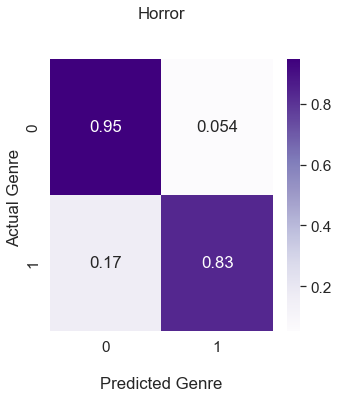

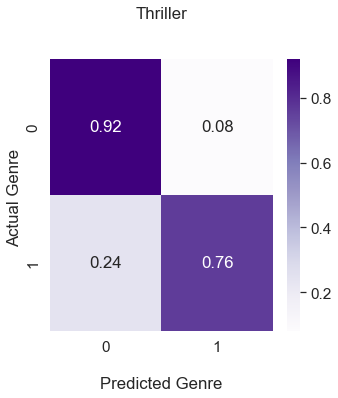

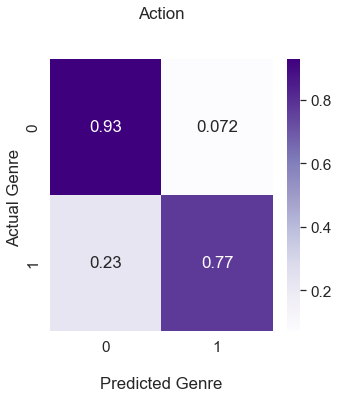

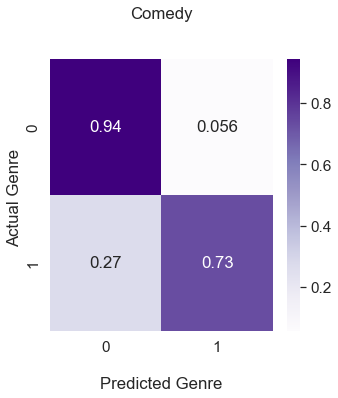

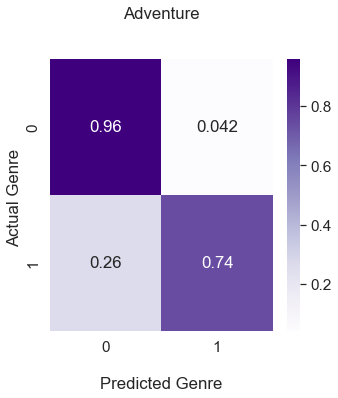

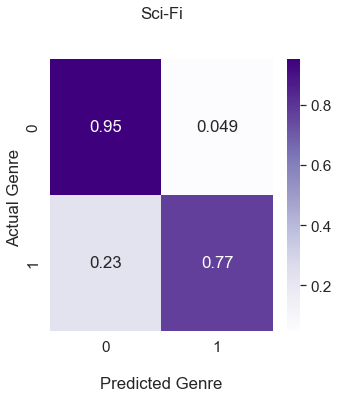

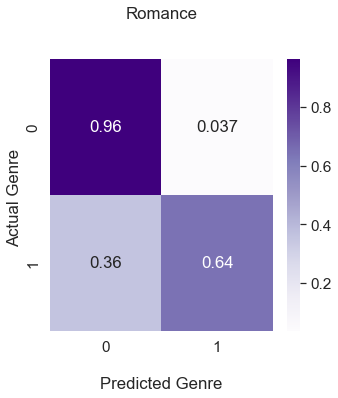

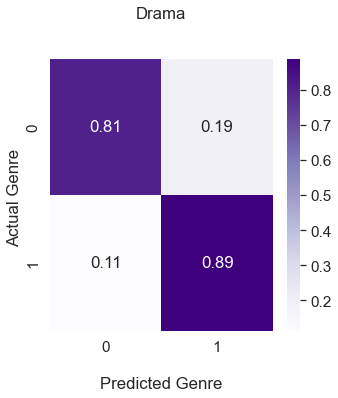

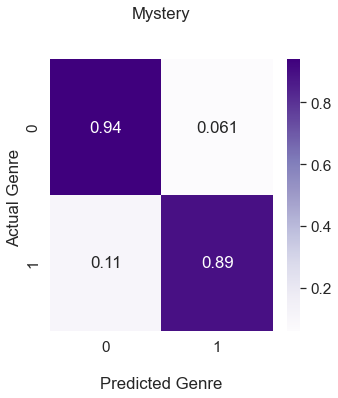

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
predictions = np.array(predictions)
actuals = np.array(actuals, dtype =int)
one_hotted_predictions = np.array(one_hotted_predictions, dtype =int)

distance_one_hot_encoded_predictions = np.copy(predictions)
mult_predictions = np.copy(predictions)
weights = list(class_weights.values())
print(predictions.shape)
meaned_predictions = [np.mean(predictions[j]) for j in range (predictions.shape[1])]
#print(meaned_predictions)
#one_hotted_predictions2 = [distance_matrix_one_hot_encoder(p-meaned_predictions) for p in predictions ]
print( classification_report(actuals, one_hotted_predictions) )

conf_mat_dict={}
for label_col in range(len(main_genre)):
        y_true_label = np.array(actuals)[:, label_col]
        y_pred_label = np.array(one_hotted_predictions )[:, label_col]

        conf_mat_dict[main_genre[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)


        cf_matrix =conf_mat_dict[main_genre[label_col]]
        np.set_printoptions(precision=2)


        conf_norm = cf_matrix.astype('float')/cf_matrix.sum(axis=1)[:,np.newaxis]
        fig, ax = plt.subplots(figsize=(5,5))  
        ax = sns.heatmap(conf_norm, annot=True, cmap='Purples',ax = ax)
        
        ax.set_title(str(main_genre[label_col])+'\n\n')
        ax.set_xlabel('\nPredicted Genre')
        ax.set_ylabel('Actual Genre ')
        sns.set(font_scale=1.4)
        ax.figure.savefig("Confusion_matrices/" + str(main_genre[label_col]))